### Problem statement:
Build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

In [3]:
!pip show google-api-python-client

Name: google-api-python-client
Version: 2.84.0
Summary: Google API Client Library for Python
Home-page: https://github.com/googleapis/google-api-python-client/
Author: Google LLC
Author-email: googleapis-packages@google.com
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: google-api-core, google-auth, google-auth-httplib2, httplib2, uritemplate
Required-by: earthengine-api, firebase-admin, PyDrive, PyDrive2


In [4]:
from google.colab import auth
from googleapiclient.discovery import build

In [5]:
auth.authenticate_user()

In [6]:
drive_service = build('drive', 'v3')

In [7]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [8]:
!ls /content/gdrive

MyDrive


In [9]:
#unzip the dataset
!unzip "/content/gdrive/MyDrive/CNN_assignment.zip" > /dev/null

In [10]:
#import the required libraries
import pathlib
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

from tensorflow.keras.preprocessing.image import load_img

In [11]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test/")

In [12]:
# Count the number of image in Train and Test directory
# Using the glob to retrieve files/pathnames matching a specified pattern.

#Train Image count
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

#Test Image count
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


#### Data Visualization

Found 2239 files belonging to 9 classes.


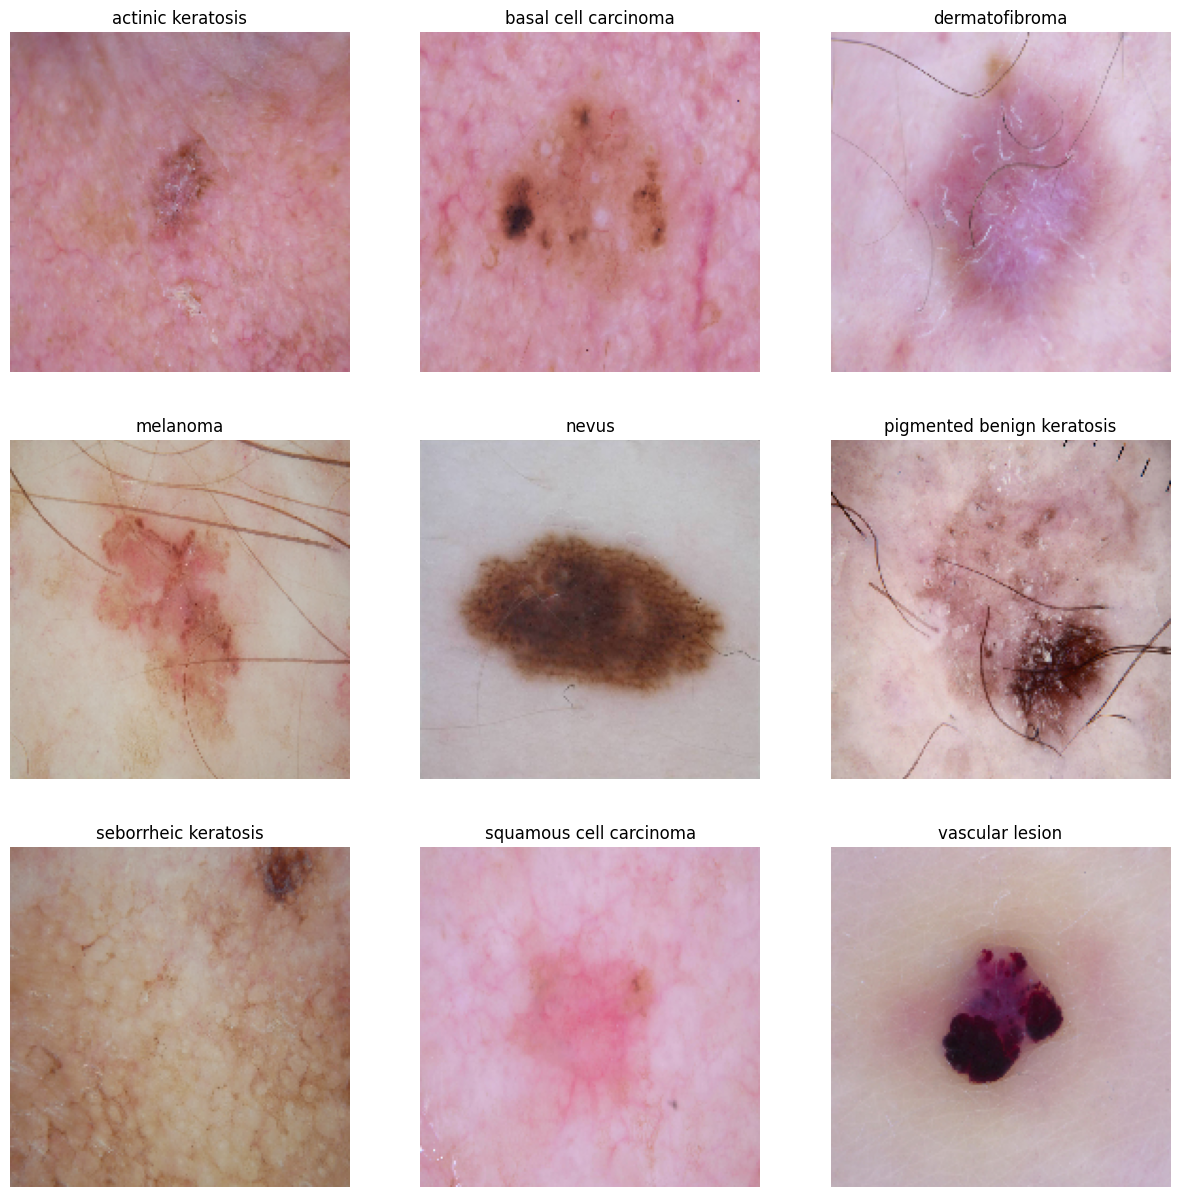

In [13]:
#Visualize one instance of all the class present in the dataset.

#image_dataset_from_directory() will return a tf.data.Dataset that yields batches of images from the subdirectories.
#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes), representing a one-hot encoding of the class index.
image_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,image_size=(180,180),
                                                                    label_mode='categorical',seed=123)

#all the classes of Skin Cancer
class_names = image_dataset.class_names

#Dictionary to store the path of image as per the class
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))

#Visualize image
plt.figure(figsize=(15,15))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

**Visualize distribution of classes in the training dataset**

In [14]:
def class_distribution_count(directory):

    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))

    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]

    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,dermatofibroma,95
1,nevus,357
2,pigmented benign keratosis,462
3,vascular lesion,139
4,seborrheic keratosis,77
5,basal cell carcinoma,376
6,squamous cell carcinoma,181
7,actinic keratosis,114
8,melanoma,438


<Axes: xlabel='No. of Image', ylabel='Class'>

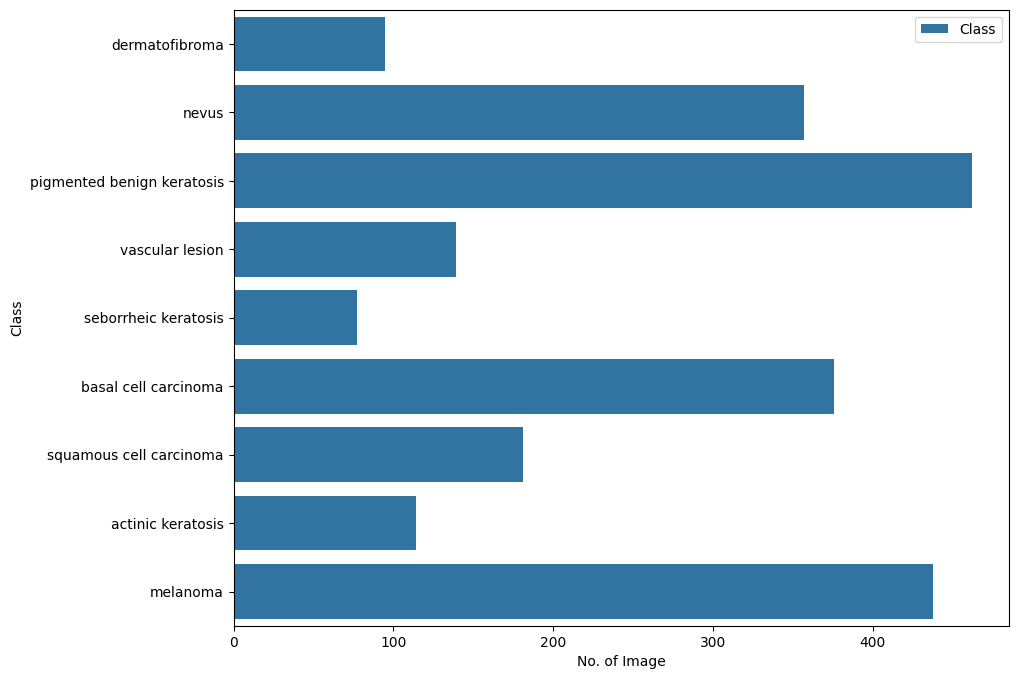

In [15]:
#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")

There is a class imbalance to solve this using a python package Augmentor

In [16]:
#install Augmentor
!pip install Augmentor

In [17]:
path_to_training_dataset="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)  #Adding 500 samples per class to make sure that none of the classes are sparse

Initialised with 114 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x79D78844B9D0>: 100%|██████████| 500/500 [00:24<00:00, 20.35 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x79D788422290>: 100%|██████████| 500/500 [00:23<00:00, 20.88 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x79D7882E5870>: 100%|██████████| 500/500 [00:19<00:00, 25.51 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x79D7887C3DC0>: 100%|██████████| 500/500 [01:30<00:00,  5.54 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x79D779CDB160>: 100%|██████████| 500/500 [01:28<00:00,  5.67 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x79D82AF318A0>: 100%|██████████| 500/500 [00:18<00:00, 26.65 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x79D788570F70>: 100%|██████████| 500/500 [00:42<00:00, 11.64 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x79D7882E5870>: 100%|██████████| 500/500 [00:21<00:00, 22.99 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x79D7885A0460>: 100%|██████████| 500/500 [00:18<00:00, 27.20 Samples/s]


In [18]:
#Count total number of image generated by Augmentor.
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


**Model Build**


In [19]:
# train dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=32,
                                                               image_size=(180,180), label_mode='categorical',
                                                               seed=123,subset="training",
                                                               validation_split=0.2)

#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes),
#representing a one-hot encoding of the class index.

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [20]:
# validation dataset
val_ds =tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,
                                                            image_size=(180,180), label_mode='categorical',
                                                            seed=123,subset="validation",
                                                            validation_split=0.2)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [21]:
#tf.data.experimental.AUTOTUNE defines appropriate number of processes that are free for working.

#`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

#`Dataset.prefetch()` overlaps data preprocessing and model execution while training.


AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [22]:
#CNN Model Architecture

#Sequential allows you to create models layer-by-layer
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))
#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       7

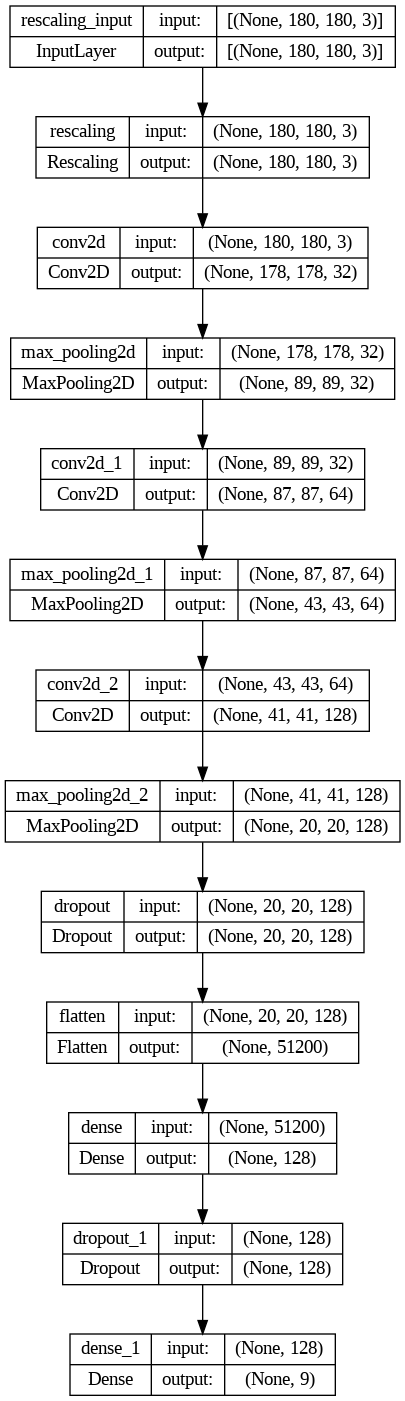

In [23]:
# vizualizing the model
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [24]:
#Compile the Model

model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

checkpoint = ModelCheckpoint("model.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)

In [25]:
# Train the model
epochs = 20
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs,callbacks=[checkpoint,earlystop])

Epoch 1/20
169/169 [==============================] - ETA: 0s - loss: 1.7302 - accuracy: 0.3431
Epoch 1: val_accuracy improved from -inf to 0.47365, saving model to model.h5
169/169 [==============================] - 432s 2s/step - loss: 1.7302 - accuracy: 0.3431 - val_loss: 1.4129 - val_accuracy: 0.4736


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/20
169/169 [==============================] - ETA: 0s - loss: 1.4093 - accuracy: 0.4624
Epoch 2: val_accuracy improved from 0.47365 to 0.54788, saving model to model.h5
169/169 [==============================] - 405s 2s/step - loss: 1.4093 - accuracy: 0.4624 - val_loss: 1.2373 - val_accuracy: 0.5479
Epoch 3/20
169/169 [==============================] - ETA: 0s - loss: 1.2369 - accuracy: 0.5412
Epoch 3: val_accuracy improved from 0.54788 to 0.56422, saving model to model.h5
169/169 [==============================] - 406s 2s/step - loss: 1.2369 - accuracy: 0.5412 - val_loss: 1.1866 - val_accuracy: 0.5642
Epoch 4/20
169/169 [==============================] - ETA: 0s - loss: 1.1421 - accuracy: 0.5729
Epoch 4: val_accuracy improved from 0.56422 to 0.60431, saving model to model.h5
169/169 [==============================] - 407s 2s/step - loss: 1.1421 - accuracy: 0.5729 - val_loss: 1.1015 - val_accuracy: 0.6043
Epoch 5/20
169/169 [==============================] - ETA: 0s - loss: 1.0

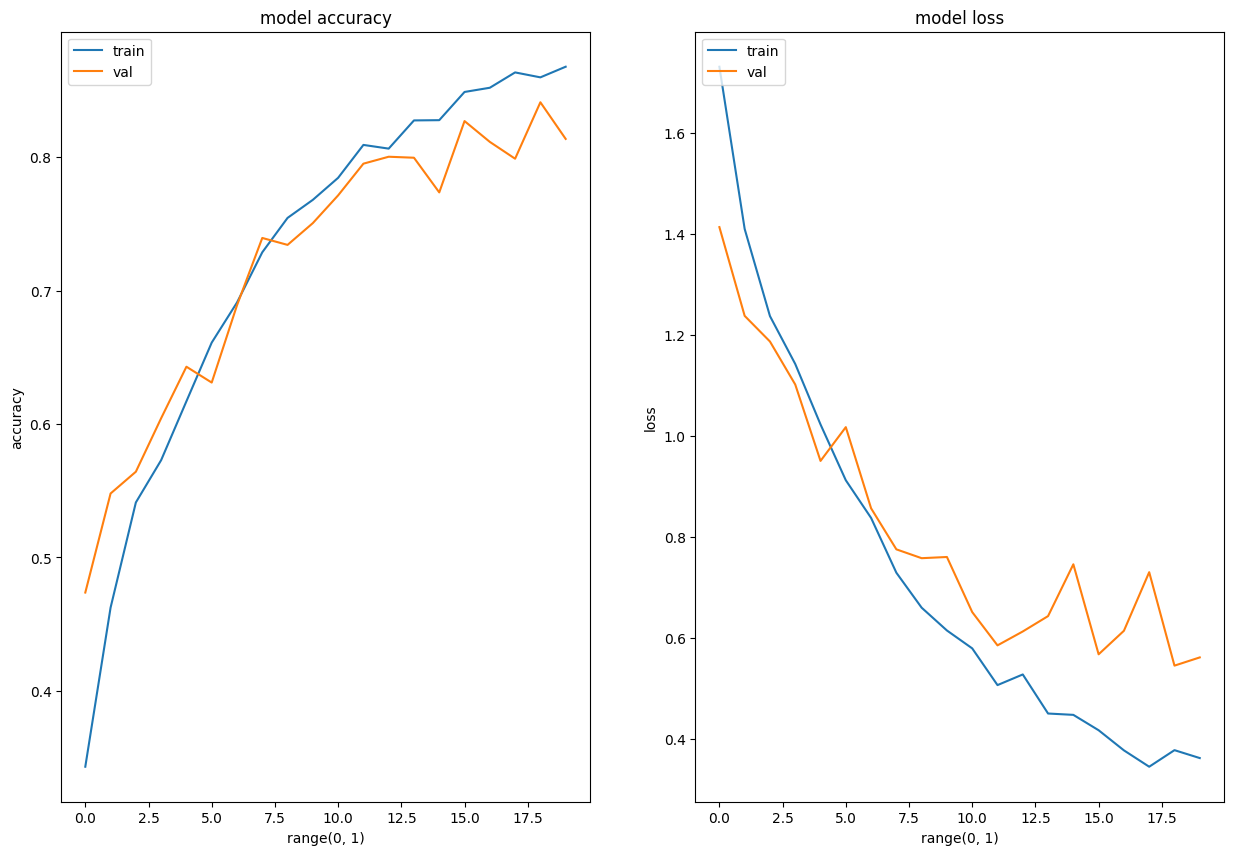

In [26]:
# Plot the training curves

epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

**Model Prediction**

1/1 [==============================] - 0s 261ms/step
Actual Class basal cell carcinoma
Predictive Class basal cell carcinoma


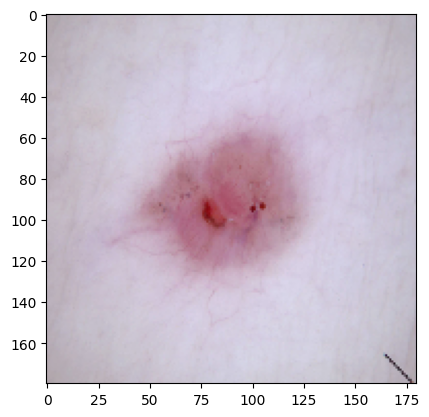

In [27]:
from glob import glob
Test_image_path = os.path.join(data_dir_test, class_names[1], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[1] +'\n'+ "Predictive Class "+pred_class )